In [1]:
from difflogic import PairedLogicLayer, InvLogicLayer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
)

# Make the dataset only 0s and 1s
# mnist_train.data = mnist_train.data[np.where((mnist_train.targets == 1) | (mnist_train.targets == 0))]
# mnist_train.targets = mnist_train.targets[np.where((mnist_train.targets == 1) | (mnist_train.targets == 0))]
# mnist_test.data = mnist_test.data[np.where((mnist_test.targets == 1) | (mnist_test.targets == 0))]
# mnist_test.targets = mnist_test.targets[np.where((mnist_test.targets == 1) | (mnist_test.targets == 0))]

# make the label 1 vs all classifier
mnist_train.targets = (mnist_train.targets == 9).int()
mnist_test.targets = (mnist_test.targets == 9).int()

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

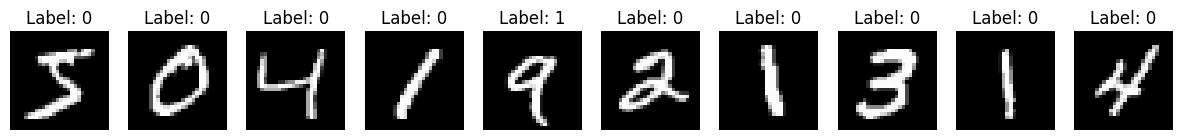

In [3]:
# Visualize the dataset
def visualize_dataset(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(dataset.data[i].numpy(), cmap='gray')
        axes[i].set_title(f"Label: {dataset.targets[i]}")
        axes[i].axis('off')
    plt.show()

visualize_dataset(mnist_train)

In [4]:
class AndLogicLayer(nn.Module):
    def __init__(self):
        super(AndLogicLayer, self).__init__()
    
    def forward(self, x):
        sum = torch.sum(x, dim=1)
        # calculate mean of list
        mean = 400.0
        # calculate std of list
        std = 11.0
        # calculate output
        output = torch.sigmoid((sum - mean) / std)
        return output

class GhostNet(nn.Module):
    def __init__(self):
        super(GhostNet, self).__init__()
        self.ghost_image = torch.zeros(28*28).unsqueeze(0).to('cuda')
        self.invert = InvLogicLayer(int(28*28), int(28*28), restricted_gates=[3,12], implementation='python')
        self.xor = PairedLogicLayer(int(28*28*2), int(28*28), restricted_gates=[9,15], implementation='python')
        self.and_gate = AndLogicLayer()
    def forward(self, x): 
        y = x.squeeze(1).reshape(-1, 28*28).to('cuda')
        z = self.invert(self.ghost_image.repeat((y.shape[0], 1)))
        z = self.xor(torch.cat((y, z), dim=1))
        z = self.and_gate(z)
        return z

In [5]:
net = GhostNet()

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data.to('cuda'))
        loss = loss_fn(output, target.to('cuda').float())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
            if batch_idx == 0:
                plt.imshow(data[0].squeeze(), cmap='gray')
                plt.title(f'Target: {target[0]}')
                plt.show()
                plt.imshow(net.ghost_image.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('Ghost Image')
                plt.show()
                plt.imshow(net.invert(net.ghost_image).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('Inverted Ghost Image')
                plt.show()
                plt.imshow(net.xor(torch.cat((net.invert(net.ghost_image), data[0].to('cuda').reshape((1, -1))), dim=1)).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
                plt.title('XOR Output')
                plt.show()
                # Print AND output
                print('AND Output:')
                print(net.and_gate(net.xor(torch.cat((net.invert(net.ghost_image), data[0].to('cuda').reshape((1, -1))), dim=1))).squeeze().detach())

def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data.to('cuda'))
            test_loss += loss_fn(output, target.to('cuda').float()).item()
            pred = output.round()
            correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

Train Epoch: 1 [0/60000] Loss: 90.058899


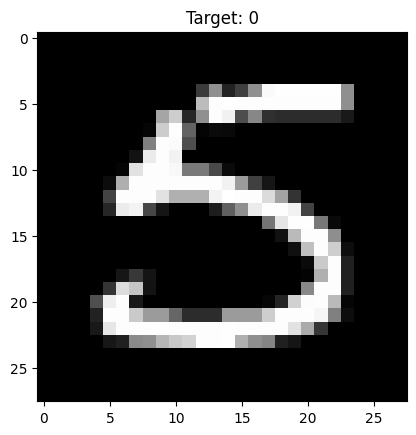

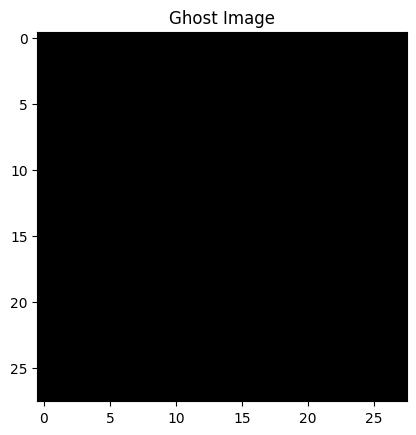

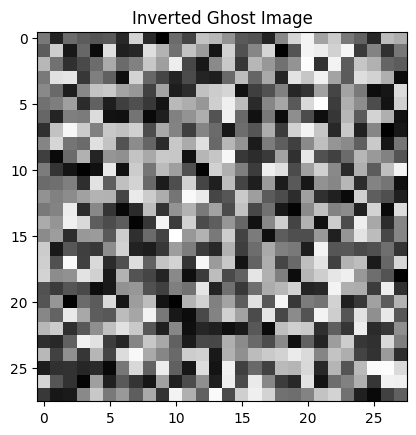

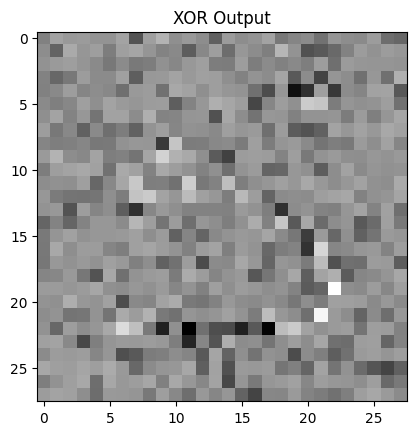

AND Output:
tensor(1., device='cuda:0')
Train Epoch: 1 [6400/60000] Loss: 11.756839
Train Epoch: 1 [12800/60000] Loss: 8.478145
Train Epoch: 1 [19200/60000] Loss: 4.949322
Train Epoch: 1 [25600/60000] Loss: 2.062262
Train Epoch: 1 [32000/60000] Loss: 0.715996
Train Epoch: 1 [38400/60000] Loss: 0.600325
Train Epoch: 1 [44800/60000] Loss: 0.601226
Train Epoch: 1 [51200/60000] Loss: 0.494789
Train Epoch: 1 [57600/60000] Loss: 0.319497
Test set: Average loss: 0.0254, Accuracy: 8991/10000 (90%)
Train Epoch: 2 [0/60000] Loss: 0.321840


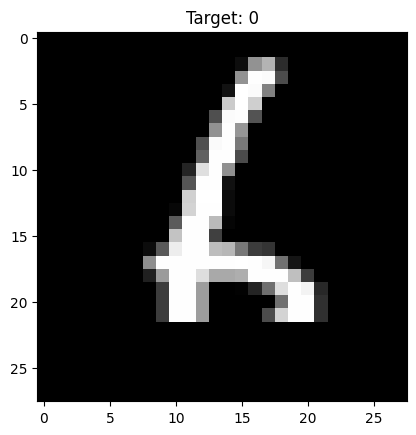

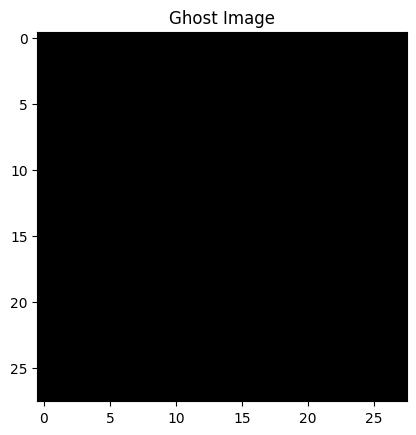

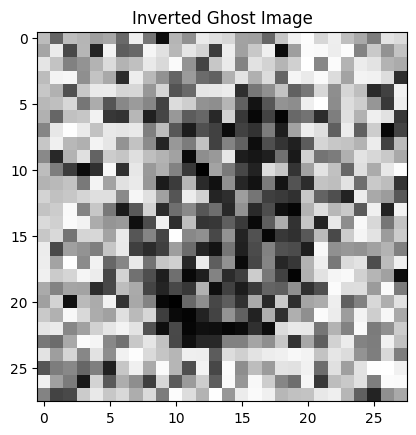

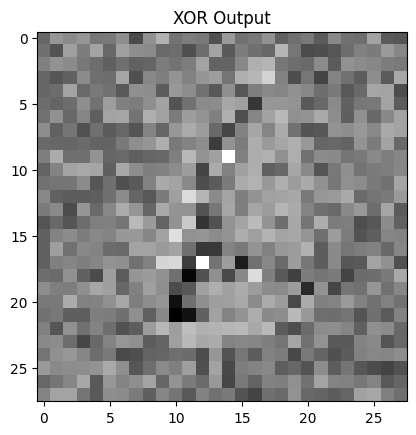

AND Output:
tensor(0.1684, device='cuda:0')
Train Epoch: 2 [6400/60000] Loss: 0.393121
Train Epoch: 2 [12800/60000] Loss: 0.353042
Train Epoch: 2 [19200/60000] Loss: 0.163725
Train Epoch: 2 [25600/60000] Loss: 0.304119
Train Epoch: 2 [32000/60000] Loss: 0.200352
Train Epoch: 2 [38400/60000] Loss: 0.265501
Train Epoch: 2 [44800/60000] Loss: 0.281755
Train Epoch: 2 [51200/60000] Loss: 0.204015
Train Epoch: 2 [57600/60000] Loss: 0.298988
Test set: Average loss: 0.0231, Accuracy: 8991/10000 (90%)
Train Epoch: 3 [0/60000] Loss: 0.209627


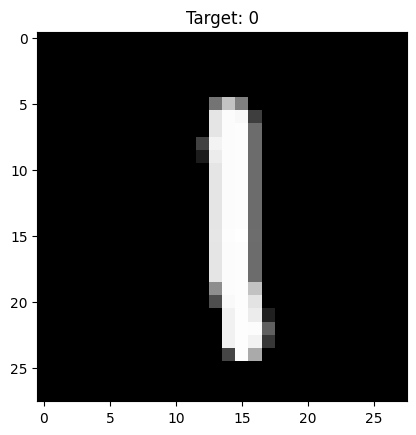

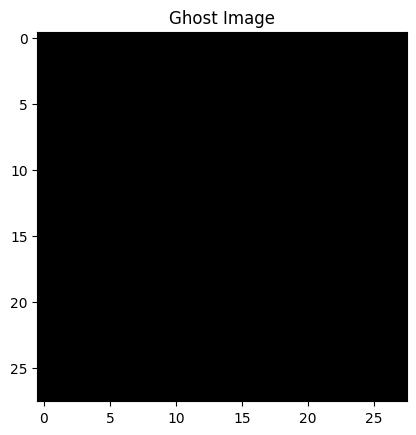

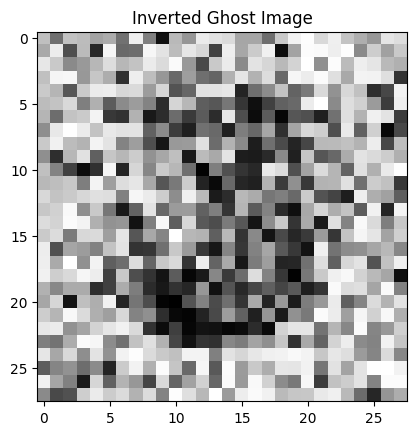

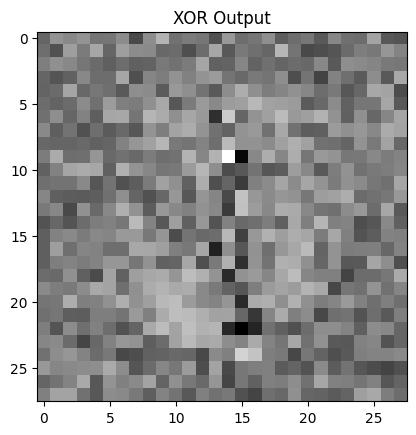

AND Output:
tensor(0.0399, device='cuda:0')
Train Epoch: 3 [6400/60000] Loss: 0.253770
Train Epoch: 3 [12800/60000] Loss: 0.260258
Train Epoch: 3 [19200/60000] Loss: 0.167767
Train Epoch: 3 [25600/60000] Loss: 0.233359
Train Epoch: 3 [32000/60000] Loss: 0.199467
Train Epoch: 3 [38400/60000] Loss: 0.293239
Train Epoch: 3 [44800/60000] Loss: 0.193531
Train Epoch: 3 [51200/60000] Loss: 0.335788
Train Epoch: 3 [57600/60000] Loss: 0.217470
Test set: Average loss: 0.0218, Accuracy: 8991/10000 (90%)
Train Epoch: 4 [0/60000] Loss: 0.312294


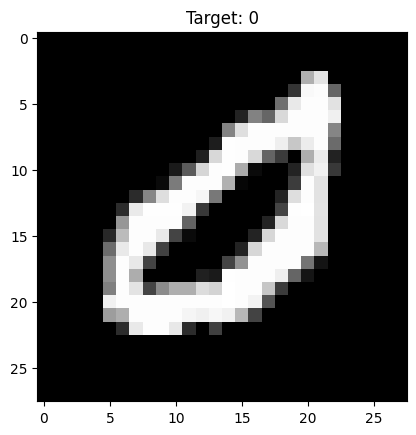

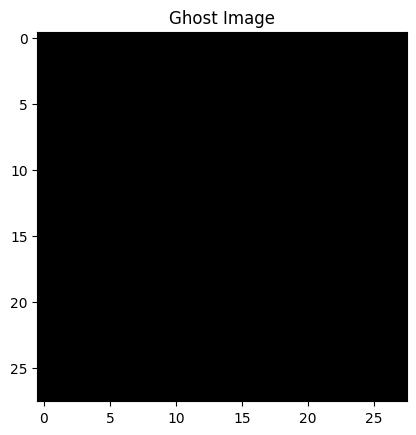

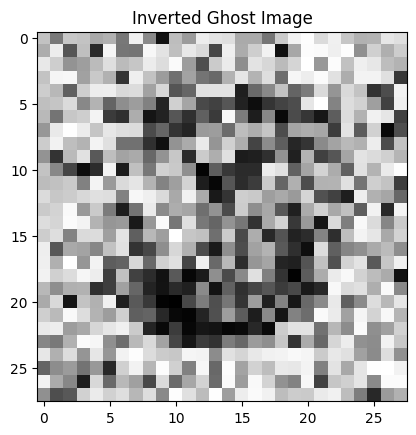

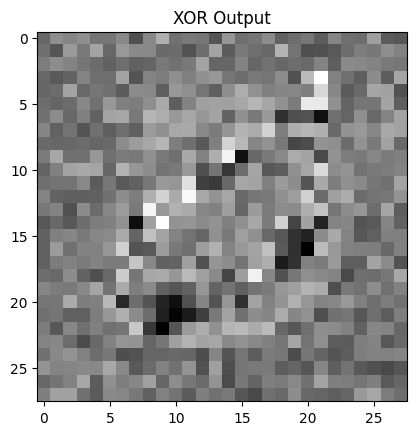

AND Output:
tensor(0.0047, device='cuda:0')
Train Epoch: 4 [6400/60000] Loss: 0.119187
Train Epoch: 4 [12800/60000] Loss: 0.244709
Train Epoch: 4 [19200/60000] Loss: 0.164177
Train Epoch: 4 [25600/60000] Loss: 0.160245
Train Epoch: 4 [32000/60000] Loss: 0.208809
Train Epoch: 4 [38400/60000] Loss: 0.203863
Train Epoch: 4 [44800/60000] Loss: 0.099157
Train Epoch: 4 [51200/60000] Loss: 0.293409
Train Epoch: 4 [57600/60000] Loss: 0.138094
Test set: Average loss: 0.0198, Accuracy: 8991/10000 (90%)
Train Epoch: 5 [0/60000] Loss: 0.120660


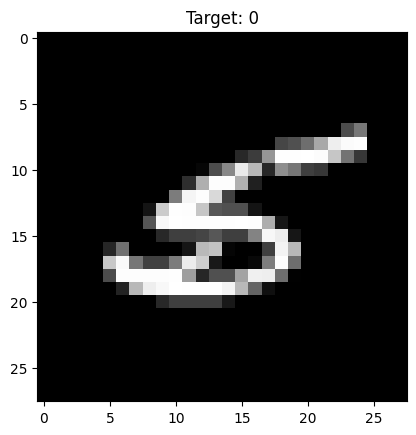

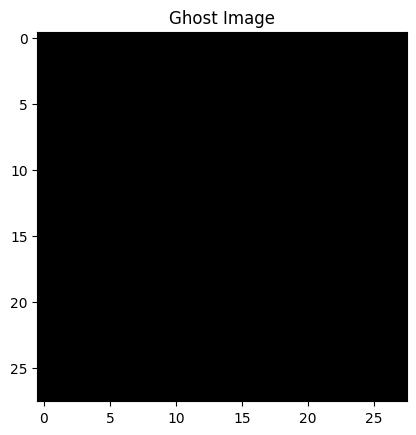

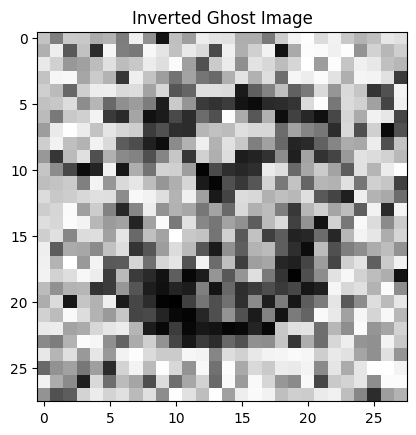

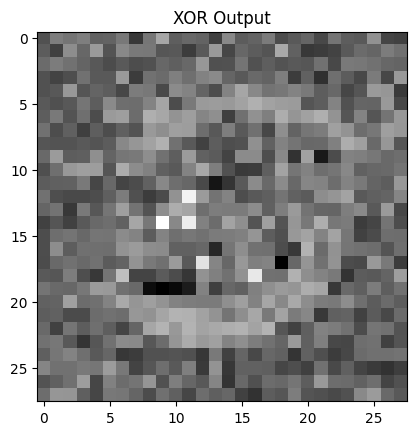

AND Output:
tensor(0.0098, device='cuda:0')
Train Epoch: 5 [6400/60000] Loss: 0.216217
Train Epoch: 5 [12800/60000] Loss: 0.173014
Train Epoch: 5 [19200/60000] Loss: 0.119497
Train Epoch: 5 [25600/60000] Loss: 0.174742
Train Epoch: 5 [32000/60000] Loss: 0.180816
Train Epoch: 5 [38400/60000] Loss: 0.151267
Train Epoch: 5 [44800/60000] Loss: 0.102371
Train Epoch: 5 [51200/60000] Loss: 0.151730
Train Epoch: 5 [57600/60000] Loss: 0.141827
Test set: Average loss: 0.0200, Accuracy: 8991/10000 (90%)
Train Epoch: 6 [0/60000] Loss: 0.167174


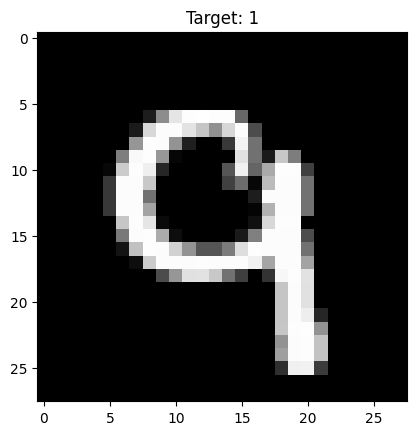

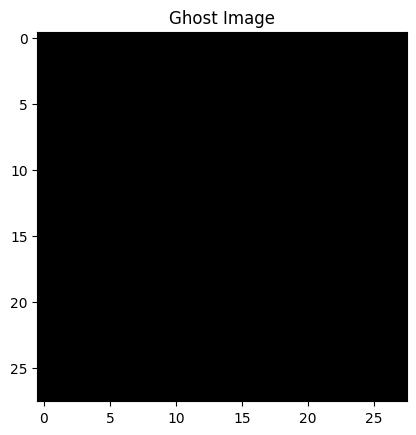

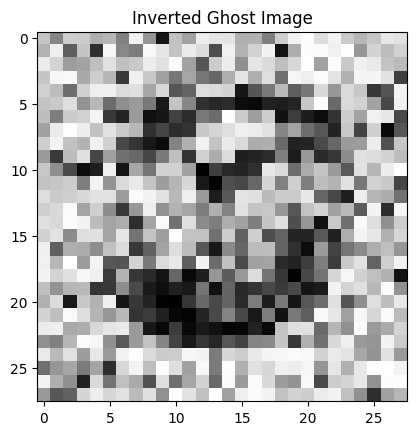

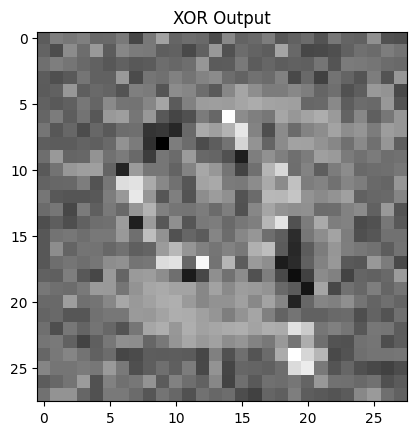

AND Output:
tensor(0.1103, device='cuda:0')
Train Epoch: 6 [6400/60000] Loss: 0.183680
Train Epoch: 6 [12800/60000] Loss: 0.111084
Train Epoch: 6 [19200/60000] Loss: 0.240856
Train Epoch: 6 [25600/60000] Loss: 0.184505
Train Epoch: 6 [32000/60000] Loss: 0.190194
Train Epoch: 6 [38400/60000] Loss: 0.060381
Train Epoch: 6 [44800/60000] Loss: 0.117473
Train Epoch: 6 [51200/60000] Loss: 0.094460
Train Epoch: 6 [57600/60000] Loss: 0.086768
Test set: Average loss: 0.0195, Accuracy: 8991/10000 (90%)
Train Epoch: 7 [0/60000] Loss: 0.057013


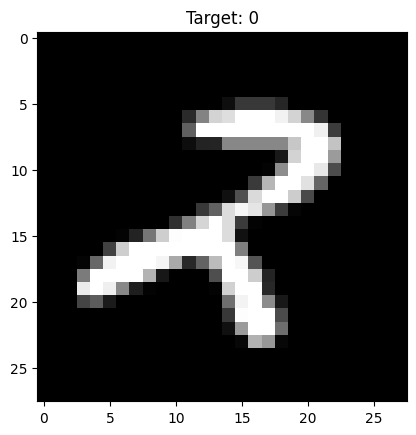

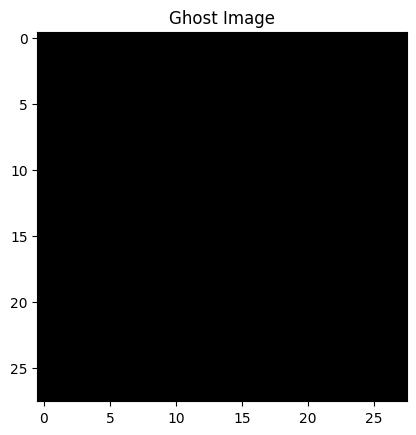

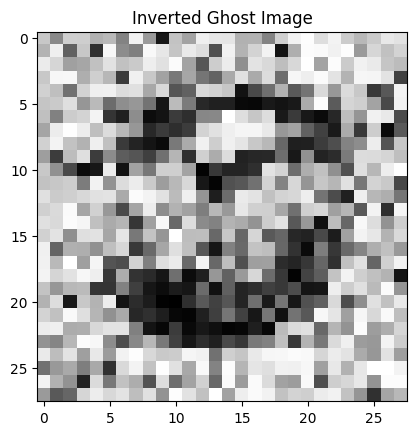

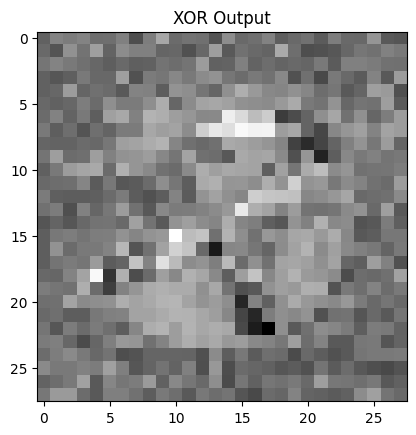

AND Output:
tensor(0.1956, device='cuda:0')
Train Epoch: 7 [6400/60000] Loss: 0.148547
Train Epoch: 7 [12800/60000] Loss: 0.196472
Train Epoch: 7 [19200/60000] Loss: 0.127102
Train Epoch: 7 [25600/60000] Loss: 0.130715
Train Epoch: 7 [32000/60000] Loss: 0.149383
Train Epoch: 7 [38400/60000] Loss: 0.201904
Train Epoch: 7 [44800/60000] Loss: 0.141106
Train Epoch: 7 [51200/60000] Loss: 0.121740
Train Epoch: 7 [57600/60000] Loss: 0.159350
Test set: Average loss: 0.0187, Accuracy: 8991/10000 (90%)
Train Epoch: 8 [0/60000] Loss: 0.048154


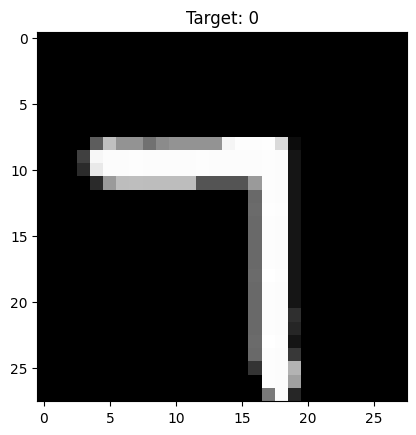

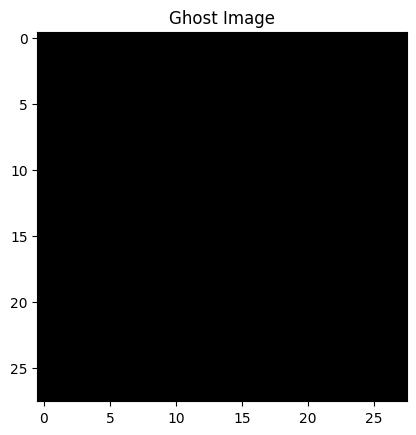

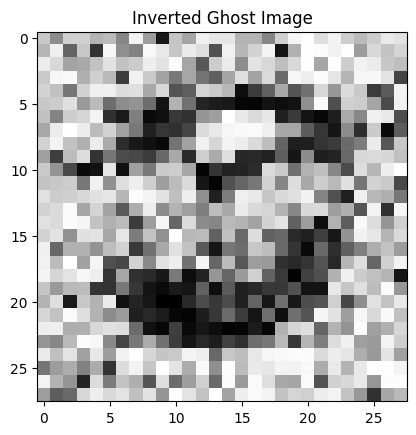

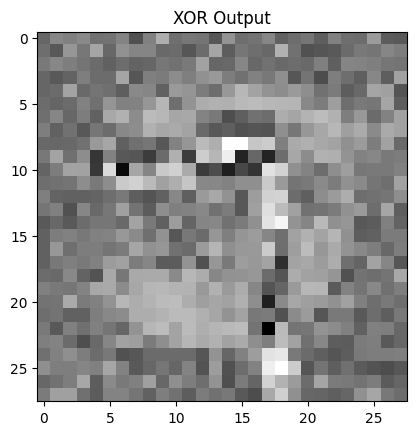

AND Output:
tensor(0.1452, device='cuda:0')
Train Epoch: 8 [6400/60000] Loss: 0.081714
Train Epoch: 8 [12800/60000] Loss: 0.052226
Train Epoch: 8 [19200/60000] Loss: 0.176166
Train Epoch: 8 [25600/60000] Loss: 0.044639
Train Epoch: 8 [32000/60000] Loss: 0.108114
Train Epoch: 8 [38400/60000] Loss: 0.224019
Train Epoch: 8 [44800/60000] Loss: 0.149354
Train Epoch: 8 [51200/60000] Loss: 0.128844
Train Epoch: 8 [57600/60000] Loss: 0.280437
Test set: Average loss: 0.0193, Accuracy: 8991/10000 (90%)
Train Epoch: 9 [0/60000] Loss: 0.167884


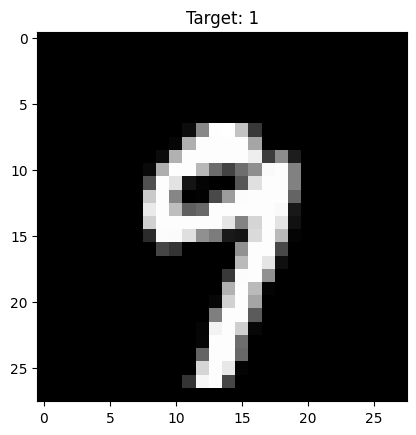

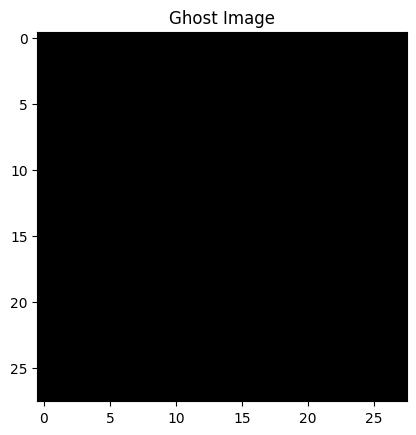

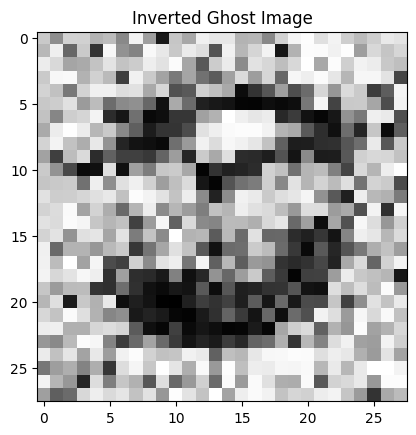

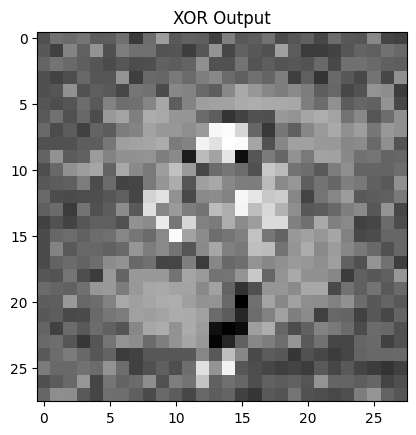

AND Output:
tensor(0.9051, device='cuda:0')
Train Epoch: 9 [6400/60000] Loss: 0.047444
Train Epoch: 9 [12800/60000] Loss: 0.197340
Train Epoch: 9 [19200/60000] Loss: 0.164504
Train Epoch: 9 [25600/60000] Loss: 0.127747
Train Epoch: 9 [32000/60000] Loss: 0.082363
Train Epoch: 9 [38400/60000] Loss: 0.232636
Train Epoch: 9 [44800/60000] Loss: 0.099416
Train Epoch: 9 [51200/60000] Loss: 0.091254
Train Epoch: 9 [57600/60000] Loss: 0.091729
Test set: Average loss: 0.0189, Accuracy: 8991/10000 (90%)
Train Epoch: 10 [0/60000] Loss: 0.272416


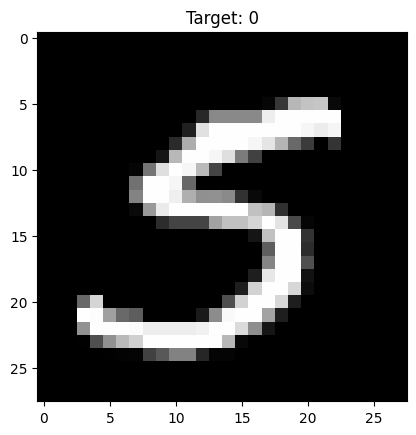

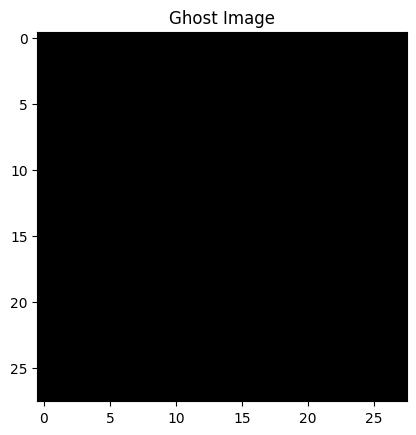

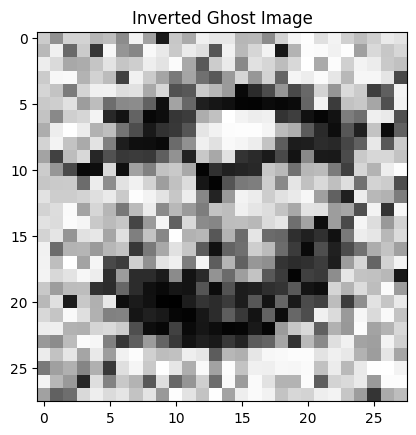

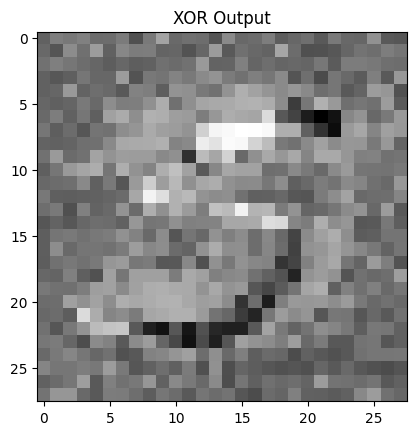

AND Output:
tensor(0.0590, device='cuda:0')
Train Epoch: 10 [6400/60000] Loss: 0.071620
Train Epoch: 10 [12800/60000] Loss: 0.141823
Train Epoch: 10 [19200/60000] Loss: 0.106110
Train Epoch: 10 [25600/60000] Loss: 0.146194
Train Epoch: 10 [32000/60000] Loss: 0.089668
Train Epoch: 10 [38400/60000] Loss: 0.051925
Train Epoch: 10 [44800/60000] Loss: 0.065265
Train Epoch: 10 [51200/60000] Loss: 0.119948
Train Epoch: 10 [57600/60000] Loss: 0.126119
Test set: Average loss: 0.0186, Accuracy: 8991/10000 (90%)


In [6]:
for epoch in range(1, 11):
    train(epoch)
    test()

In [7]:
# Save model for 1 vs all classifier
torch.save(net.state_dict(), 'ghostnet_mnist_9_new.pth')

torch.Size([64, 1, 28, 28])
torch.Size([64])
Element: 7
Target: tensor(1)


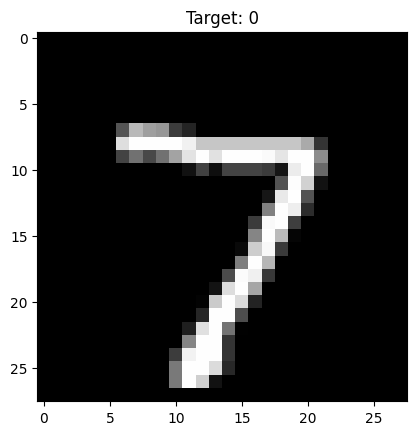

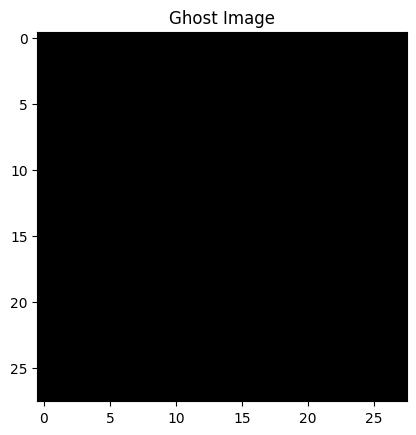

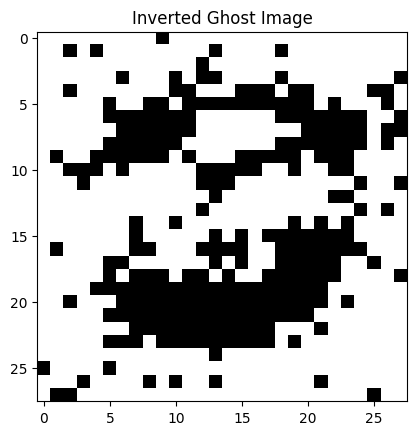

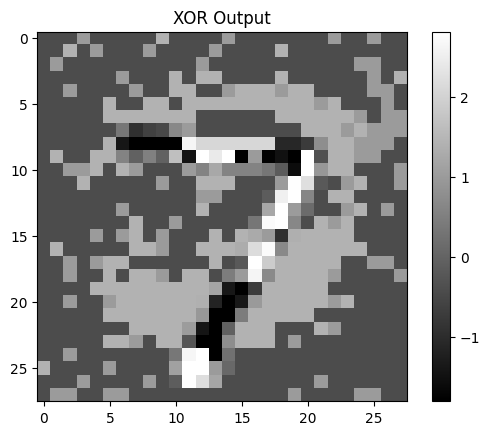

AND Output:
tensor(3.8548e-09, device='cuda:0')


In [8]:
(data, target) = next(iter(test_loader))
print(data.shape)
print(target.shape)

# Get a datapoint that is of class 1
for i in range(len(data)):
    if target[i] == 1:
        element = i
        break
print('Element:', element)
print('Target:', target[element])
element=0
net.eval()
plt.imshow(data[element].squeeze(), cmap='gray')
plt.title(f'Target: {target[element]}')
plt.show()
plt.imshow(net.ghost_image.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('Ghost Image')
plt.show()
plt.imshow(net.invert(net.ghost_image).cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('Inverted Ghost Image')
plt.show()
xor = net.xor(torch.cat((data[element].to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
# xor = net.xor(torch.cat((torch.ones(28*28).to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
# Keep all values below the threshold, and set the rest to 0
# threshold = 1.8
# thresholded_xor = torch.absolute(torch.where(torch.absolute(xor) > threshold, xor, torch.tensor(threshold).to('cuda')))
plt.imshow(xor.cpu().squeeze().detach().reshape((28, 28)), cmap='gray')
plt.title('XOR Output')
plt.colorbar()
plt.show()

# Print AND output
print('AND Output:')
print(net.and_gate(xor).squeeze().detach())

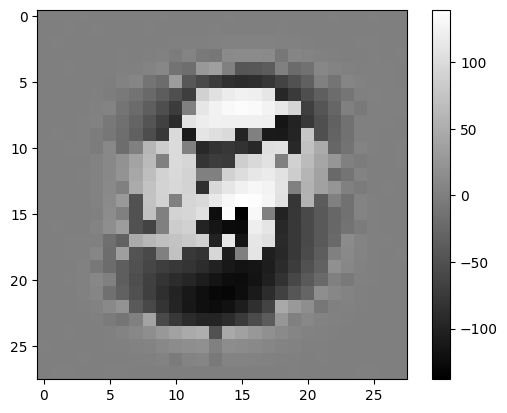

In [9]:
# Get the xor output for all the data in the dataset
net.eval()
data = train_loader.dataset.data
xor_outputs = []
for i in range(len(data)):
    xor = net.xor(torch.cat((data[i].to('cuda').reshape((1, -1)), net.invert(net.ghost_image)), dim=1))
    xor_outputs.append(xor.cpu().squeeze().detach().reshape((28, 28)))
xor_outputs = torch.stack(xor_outputs)
# Plot the average of the xor outputs
avg_xor_output = torch.mean(xor_outputs, dim=0)
plt.imshow(avg_xor_output, cmap='gray')
plt.colorbar()